# Modeling and Simulation in Python

Chapter 13

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from previous chapters

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [2]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= np.sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', label='Susceptible')
    plot(I, '-', label='Infected')
    plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

In [4]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an updated version of `run_simulation` that uses `unpack`.

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

**Exercise:** Write a version of `update_func` that uses `unpack`.

In [6]:
# Original

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    
    s, i, r = state

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [6]:
#now with unpack!
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state

    infected = beta * i * s    
    recovered = gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

Test the updated code with this example.

In [7]:
system = make_system(0.333, 0.25)
results = run_simulation(system, update_func)
results.head()

,S,I,R
0,0.988889,0.011111,0.000000
1,0.985230,0.011992,0.002778
2,0.981296,0.012929,0.005776
3,0.977071,0.013921,0.009008
4,0.972541,0.014970,0.012488


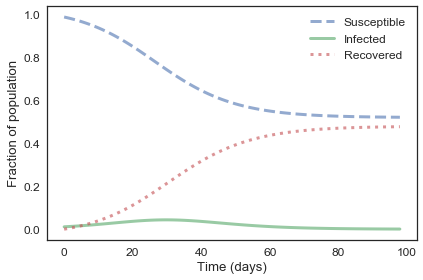

In [8]:
plot_results(results.S, results.I, results.R)

### Sweeping beta

Make a range of values for `beta`, with constant `gamma`.

In [9]:
beta_array = linspace(0.1, 1.1, 11)
gamma = 0.25

0.25

Run the simulation once for each value of `beta` and print total infections.

In [10]:
for beta in beta_array:
    system = make_system(beta, gamma)
    results = run_simulation(system, update_func)
    print(system.beta, calc_total_infected(results))

0.1 0.0072309016649785285
0.2 0.038410532615067994
0.30000000000000004 0.33703425948982
0.4 0.6502429153895082
0.5 0.8045061124629623
0.6 0.8862866308018508
0.7000000000000001 0.9316695082755875
0.8 0.9574278300784942
0.9 0.9720993156325133
1.0 0.9803437149675784
1.1 0.9848347293510136


Wrap that loop in a function and return a `SweepSeries` object.

In [11]:
def sweep_beta(beta_array, gamma):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma)
        results = run_simulation(system, update_func)
        sweep[system.beta] = calc_total_infected(results)
    return sweep

Sweep `beta` and plot the results.

In [12]:
infected_sweep = sweep_beta(beta_array, gamma)

,values
0.1,0.007231
0.2,0.038411
0.3,0.337034
0.4,0.650243
0.5,0.804506
0.6,0.886287
0.7,0.931670
0.8,0.957428
0.9,0.972099
1.0,0.980344


Saving figure to file figs/chap06-fig01.pdf


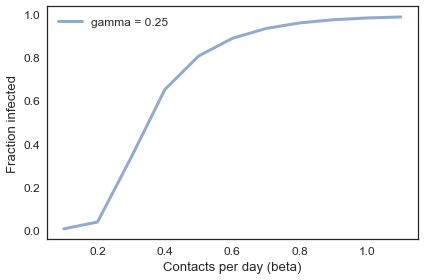

In [13]:
label = 'gamma = ' + str(gamma)
plot(infected_sweep, label=label)

decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected')

savefig('figs/chap06-fig01.pdf')

### Sweeping gamma

Using the same array of values for `beta`

In [14]:
beta_array

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

And now an array of values for `gamma`

In [15]:
gamma_array = [0.2, 0.4, 0.6, 0.8]

[0.2, 0.4, 0.6, 0.8]

For each value of `gamma`, sweep `beta` and plot the results.

Saving figure to file figs/chap06-fig02.pdf


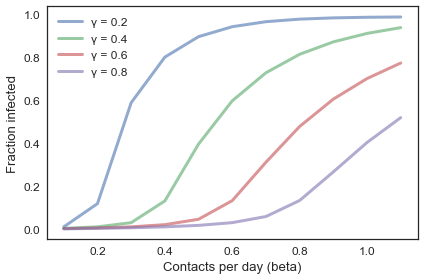

In [16]:
for gamma in gamma_array:
    infected_sweep = sweep_beta(beta_array, gamma)
    label = 'γ = ' + str(gamma)
    plot(infected_sweep, label=label)
    
decorate(xlabel='Contacts per day (beta)',
         ylabel='Fraction infected',
         loc='upper left')

savefig('figs/chap06-fig02.pdf')

** Exercise:**  Suppose the infectious period for the Freshman Plague is known to be 2 days on average, and suppose during one particularly bad year, 40% of the class is infected at some point.  Estimate the time between contacts.

In [17]:
gamma = 1/2
infected_sweep = sweep_beta(beta_array, gamma)

,values
0.1,0.002736
0.2,0.007235
0.3,0.015929
0.4,0.038603
0.5,0.132438
0.6,0.346765
0.7,0.530585
0.8,0.661553
0.9,0.754595
1.0,0.821534


In [19]:
#eyeballing the result
1/0.65

1.5384615384615383

In [20]:
# Solution goes here